# Tutorial — NumPy, Pandas, and Time Series Foundations

**Goal**
- Use NumPy for array creation, vectorized math, and basic statistics
- Use Pandas to create and explore DataFrames
- Generate a synthetic daily dataset, save it to CSV, and reload it
- Work with timestamps: parsing, indexing, and slicing
- Core time-series operations: resampling, rolling, shifting, and percent change

**Outcome.** By the end of this session you will have built a small time-series pipeline end-to-end.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%config InlineBackend.figure_format = 'retina'

# Reproducibility
np.random.seed(42)

# Display options
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)


## A. NumPy essentials

NumPy arrays are the numerical backbone under Pandas. Begin with creation and inspection.


In [36]:
# Creating arrays
a = np.array([2, 4, 6, 8])
b = np.arange(0, 10, 2)           # 0..8 step 2
c = np.linspace(0, 1, 5)          # 5 points between 0 and 1 inclusive
z = np.zeros((2, 3))
o = np.ones((3, 2))

a, b, c, z, z.shape, o, o.dtype


(array([2, 4, 6, 8]),
 array([0, 2, 4, 6, 8]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([[0., 0., 0.],
        [0., 0., 0.]]),
 (2, 3),
 array([[1., 1.],
        [1., 1.],
        [1., 1.]]),
 dtype('float64'))

In [37]:
# Indexing, slicing, and broadcasting

M = np.arange(12).reshape(3, 4)
print("M:\n", M)

# Indexing and slicing
print("M[0, 1] ->", M[0, 1])
print("M[1, :] ->", M[1, :])
print("M[:, 2] ->", M[:, 2])
print("M[1:, 1:3] ->\n", M[1:, 1:3])

# Broadcasting example
v = np.array([10, 20, 30, 40])
print("M + v ->\n", M + v)


M:
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
M[0, 1] -> 1
M[1, :] -> [4 5 6 7]
M[:, 2] -> [ 2  6 10]
M[1:, 1:3] ->
 [[ 5  6]
 [ 9 10]]
M + v ->
 [[10 21 32 43]
 [14 25 36 47]
 [18 29 40 51]]


In [38]:
# Vectorized operations and aggregations

x = np.random.normal(loc=0, scale=1, size=100_000)
print('x.shape = ', x.shape)
print('x.mean() = ', x.mean())
print('x.std() = ', x.std())
print('x.min() = ', x.min())
print('x.max() = ', x.max())


x.shape =  (100000,)
x.mean() =  0.0009668681409495966
x.std() =  1.0009009542948903
x.min() =  -4.4656038635288775
x.max() =  4.479084251025757


In [39]:
# Vectorized vs loop timing (illustrative)
y = np.random.normal(size=100_000)

# Vectorized square
%timeit x**2

# Pure Python loop (slower)
def square_loop(arr):
    out = []
    for val in arr:
        out.append(val*val)
    return out

%timeit square_loop(y)


12.6 μs ± 78.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
4.61 ms ± 7.36 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## B. Pandas basics

Pandas provides labeled 1D (Series) and 2D (DataFrame) structures built on top of NumPy.


In [40]:
# Series
s = pd.Series([3.5, 4.2, 5.1], name="score")
s


0    3.5
1    4.2
2    5.1
Name: score, dtype: float64

In [41]:
# DataFrame from a dictionary of lists
df_small = pd.DataFrame({
    "student": ["Ava", "Ben", "Chen", "Dina"],
    "age": [24, 23, 25, 24],
    "grade": [88, 73, 91, 84],
})
df_small


,student,age,grade
0,Ava,24,88
1,Ben,23,73
2,Chen,25,91
3,Dina,24,84


In [42]:
df_small.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   student  4 non-null      object
 1   age      4 non-null      int64 
 2   grade    4 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 228.0+ bytes


In [43]:
# Column selection, row selection, boolean filtering
df_small["grade"]                                # column


0    88
1    73
2    91
3    84
Name: grade, dtype: int64

In [44]:
df_small.loc[1:2, ["student", "grade"]]          # label-based


,student,grade
1,Ben,73
2,Chen,91


In [45]:
df_small.iloc[:2, :2]                            # integer-based


,student,age
0,Ava,24
1,Ben,23


In [46]:
df_small[df_small["grade"] >= 85]                # filter

,student,age,grade
0,Ava,24,88
2,Chen,25,91


In [47]:
df_small.sort_values(by=["grade", "age"], ascending=[False, True])


,student,age,grade
2,Chen,25,91
0,Ava,24,88
3,Dina,24,84
1,Ben,23,73


## C. Generate → Save → Reload

Simulate a daily sales series containing a trend, weekly seasonality, promotions, and random noise.


In [48]:
# Time axis
dates = pd.date_range(start="2024-01-01", periods=200, freq="D")

# Components
trend = np.linspace(100, 160, len(dates))                                        # upward trend
weekly = 10 * np.sin(2 * np.pi * np.arange(len(dates)) / 7)                      # weekly seasonality
promo = (np.random.rand(len(dates)) < 0.2).astype(int)                           # 20% promotion days
noise = np.random.normal(0, 5, len(dates))                                       # random noise

# Sales = baseline + effects
sales = trend + weekly + 20 * promo + noise
sales = np.maximum(sales, 0).round(2)

data = pd.DataFrame({
    "date": dates,
    "sales": sales,
    "promo": promo
})

data.head()


,date,sales,promo
0,2024-01-01,90.99,0
1,2024-01-02,106.02,0
2,2024-01-03,102.12,0
3,2024-01-04,102.83,0
4,2024-01-05,98.09,0


In [49]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    200 non-null    datetime64[ns]
 1   sales   200 non-null    float64       
 2   promo   200 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.8 KB


In [50]:
data.describe()

,date,sales,promo
count,200,200.000000,200.000000
mean,2024-04-09 12:00:00,133.897600,0.185000
min,2024-01-01 00:00:00,90.290000,0.000000
25%,2024-02-19 18:00:00,114.845000,0.000000
50%,2024-04-09 12:00:00,135.305000,0.000000
75%,2024-05-29 06:00:00,149.750000,0.000000
max,2024-07-18 00:00:00,188.370000,1.000000
std,NaN,21.953668,0.389272


In [51]:
# Save to CSV (no index) and reload

csv_path = "sales_daily.csv"
data.to_csv(csv_path, index=False)
print(f"Saved to: {csv_path}")


Saved to: sales_daily.csv


In [52]:
loaded = pd.read_csv(csv_path, parse_dates=True)
loaded.head()


,date,sales,promo
0,2024-01-01,90.99,0
1,2024-01-02,106.02,0
2,2024-01-03,102.12,0
3,2024-01-04,102.83,0
4,2024-01-05,98.09,0


## D. Timestamp handling

Core steps
- Parse timestamps with `pd.to_datetime`
- Use a `DateTimeIndex` for time-aware slicing and resampling
- Ensure the index is sorted and set an explicit daily frequency


In [53]:
loaded["date"] = pd.to_datetime(loaded["date"])  # naive timestamps
ts = loaded.set_index("date").sort_index()
ts.index.is_monotonic_increasing, ts.index.freq


(True, None)

In [54]:
ts = ts.asfreq("D")
ts.index.freq


<Day>

In [55]:
tmp = loaded.copy()
tmp["date"] = pd.to_datetime(tmp["date"])
tmp["dow"] = tmp["date"].dt.dayofweek          # Monday=0
tmp["dow_name"] = tmp["date"].dt.day_name()
tmp["is_month_end"] = tmp["date"].dt.is_month_end
tmp.head()


,date,sales,promo,dow,dow_name,is_month_end
0,2024-01-01,90.99,0,0,Monday,False
1,2024-01-02,106.02,0,1,Tuesday,False
2,2024-01-03,102.12,0,2,Wednesday,False
3,2024-01-04,102.83,0,3,Thursday,False
4,2024-01-05,98.09,0,4,Friday,False


## E. Slicing and grouping in time

String-based slicing works naturally on a `DateTimeIndex`.


In [56]:
ts.loc["2024-03"].head(3)           # March 2024


,sales,promo
date,,
2024-03-01,131.32,1
2024-03-02,106.64,0
2024-03-03,116.23,0


In [57]:
ts.loc["2024-03-10":"2024-03-20", ["sales", "promo"]]


,sales,promo
date,,
2024-03-10,116.06,0
2024-03-11,127.92,0
2024-03-12,134.31,0
2024-03-13,137.99,0
2024-03-14,129.24,0
2024-03-15,131.41,0
2024-03-16,117.74,0
2024-03-17,114.50,0
2024-03-18,128.39,0


In [58]:
# Aggregation by month via resample
monthly = ts.resample("ME").agg({"sales": ["sum", "mean"], "promo": "sum"})
monthly


sales             promo
                sum        mean   sum
date                                 
2024-01-31  3303.85  106.575806     4
2024-02-29  3316.55  114.363793     3
2024-03-31  3970.39  128.077097     7
2024-04-30  4084.34  136.144667     6
2024-05-31  4483.59  144.631935     5
2024-06-30  4689.44  156.314667     8
2024-07-31  2931.36  162.853333     4

## F. Resampling, rolling, shifting

Resampling changes the time resolution.
- Weekly totals (sum)
- Monthly averages (mean)


In [59]:
weekly = ts.resample("W").sum(numeric_only=True)
monthly_mean = ts.resample("ME").mean(numeric_only=True)
weekly.head(), monthly_mean.head()


(             sales  promo
 date                     
 2024-01-07  708.49      1
 2024-01-14  748.92      1
 2024-01-21  746.24      1
 2024-01-28  748.98      0
 2024-02-04  764.67      1,
                  sales     promo
 date                            
 2024-01-31  106.575806  0.129032
 2024-02-29  114.363793  0.103448
 2024-03-31  128.077097  0.225806
 2024-04-30  136.144667  0.200000
 2024-05-31  144.631935  0.161290)

In [60]:
ts["sales_ma7"] = ts["sales"].rolling(window=7, min_periods=1).mean()
ts[["sales", "sales_ma7"]].head(10)


,sales,sales_ma7
date,,
2024-01-01,90.99,90.990000
2024-01-02,106.02,98.505000
2024-01-03,102.12,99.710000
2024-01-04,102.83,100.490000
2024-01-05,98.09,100.010000
2024-01-06,94.07,99.020000
2024-01-07,114.37,101.212857
2024-01-08,104.55,103.150000
2024-01-09,107.76,103.398571


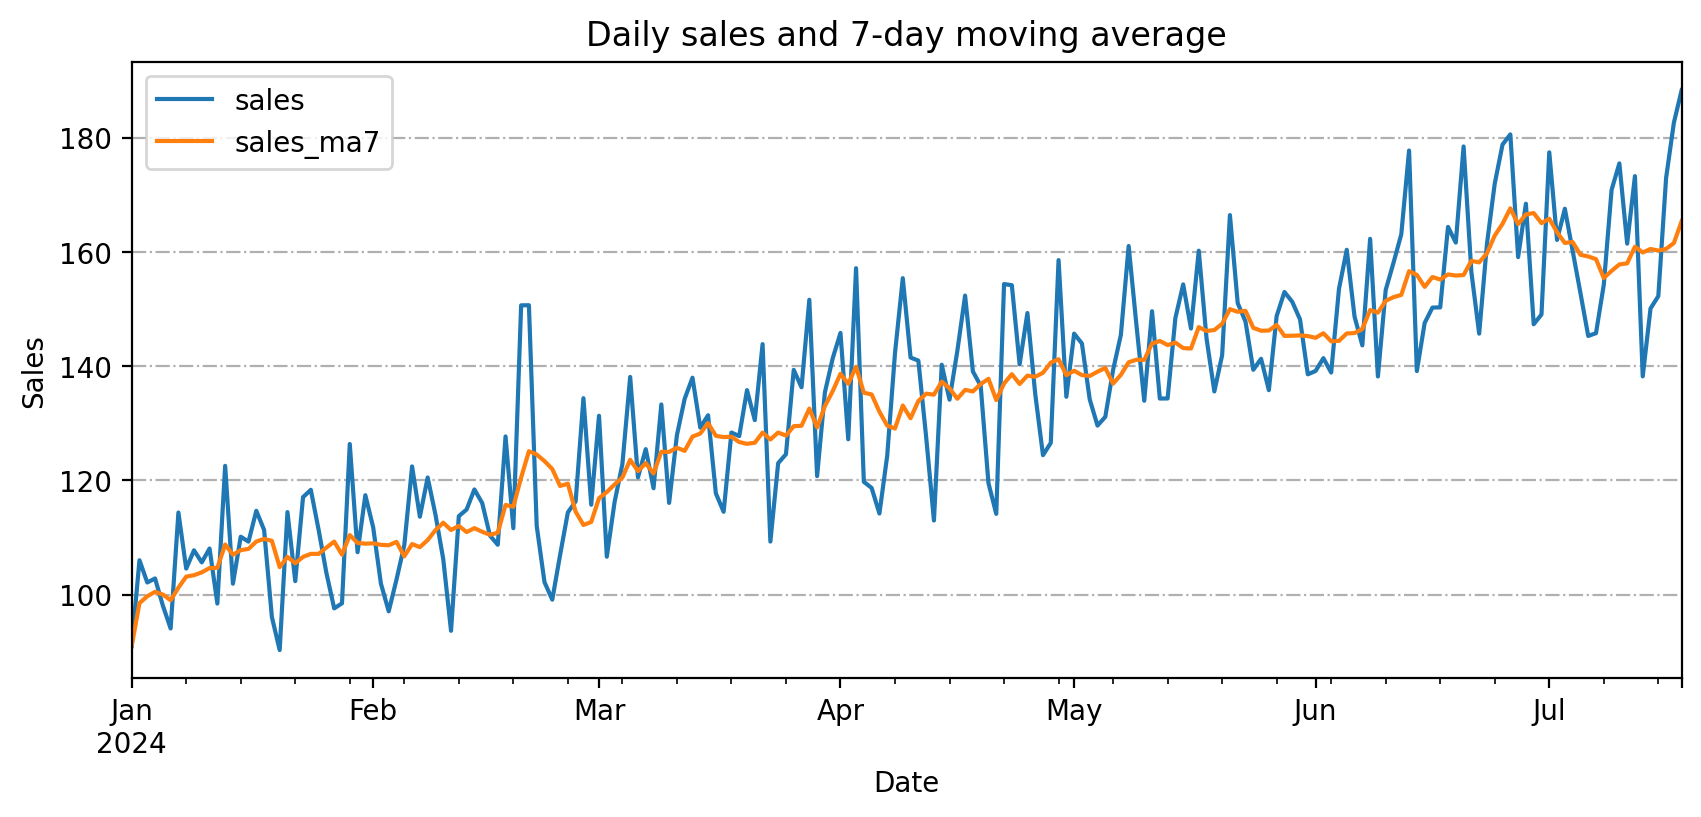

In [61]:
ax = ts[["sales", "sales_ma7"]].plot(figsize=(10, 4), title="Daily sales and 7-day moving average")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
plt.grid(axis='y', linestyle='-.')
plt.show()


In [62]:
ts["sales_lag1"] = ts["sales"].shift(1)
ts["sales_pct_change"] = ts["sales"].pct_change()
ts[["sales", "sales_lag1", "sales_pct_change"]].head(8)


,sales,sales_lag1,sales_pct_change
date,,,
2024-01-01,90.99,NaN,NaN
2024-01-02,106.02,90.99,0.165183
2024-01-03,102.12,106.02,-0.036786
2024-01-04,102.83,102.12,0.006953
2024-01-05,98.09,102.83,-0.046095
2024-01-06,94.07,98.09,-0.040983
2024-01-07,114.37,94.07,0.215797
2024-01-08,104.55,114.37,-0.085862


## G. Practical checks and fixes

Real data often has gaps. Detect and fill missing timestamps.


In [63]:
# Introduce a gap for demonstration
ts_gap = ts.drop(ts.index[50:55])              # remove 5 days
full_index = pd.date_range(ts_gap.index.min(), ts_gap.index.max(), freq="D")
ts_filled = ts_gap.reindex(full_index)

missing_count = ts_filled["sales"].isnull().sum()
missing_count


np.int64(5)

In [64]:
# Fill strategies (choose based on context)
ts_filled["sales_ffill"] = ts_filled["sales"].ffill()
ts_filled["sales_interp"] = ts_filled["sales"].interpolate(method="time")
ts_filled[["sales", "sales_ffill", "sales_interp"]].iloc[45:65]


,sales,sales_ffill,sales_interp
2024-02-15,116.04,116.04,116.040
2024-02-16,110.34,110.34,110.340
2024-02-17,108.73,108.73,108.730
2024-02-18,127.70,127.70,127.700
2024-02-19,111.63,111.63,111.630
2024-02-20,NaN,111.63,110.845
2024-02-21,NaN,111.63,110.060
2024-02-22,NaN,111.63,109.275
2024-02-23,NaN,111.63,108.490
2024-02-24,NaN,111.63,107.705


## H. Useful patterns


In [65]:
dow_counts = ts.index.day_name().value_counts()
dow_counts


date
Monday       29
Tuesday      29
Wednesday    29
Thursday     29
Friday       28
Saturday     28
Sunday       28
Name: count, dtype: int64

In [66]:
conditions = [
    ts["sales"] < ts["sales"].median(),
    ts["sales"].between(ts["sales"].median(), ts["sales"].quantile(0.75), inclusive="left"),
    ts["sales"] >= ts["sales"].quantile(0.75)
]
choices = ["low", "medium", "high"]
ts["sales_bucket"] = np.select(conditions, choices, default="medium")
ts["sales_bucket"].value_counts()


sales_bucket
low       100
high       50
medium     50
Name: count, dtype: int64

## I. Save engineered features and reload

Persist intermediate datasets to support reproducible pipelines.


In [67]:
feature_path = "sales_daily_features.csv"
ts.reset_index().rename(columns={"index": "date"}).to_csv(feature_path, index=False)
print(f"Saved to: {feature_path}")


Saved to: sales_daily_features.csv


In [68]:
features = pd.read_csv(feature_path, parse_dates=["date"]).set_index("date").sort_index()
features.head()


,sales,promo,sales_ma7,sales_lag1,sales_pct_change,sales_bucket
date,,,,,,
2024-01-01,90.99,0,90.990,NaN,NaN,low
2024-01-02,106.02,0,98.505,90.99,0.165183,low
2024-01-03,102.12,0,99.710,106.02,-0.036786,low
2024-01-04,102.83,0,100.490,102.12,0.006953,low
2024-01-05,98.09,0,100.010,102.83,-0.046095,low


## J. Wrap-up

What we covered
- NumPy arrays and vectorized math for performance
- Pandas Series/DataFrame creation and inspection
- End-to-end CSV round trip: generate → save → reload
- Timestamps: parsing, DateTimeIndex, slicing
- Time-series operations: resampling, rolling, shift, percent change
- Practical fixes: missing timestamps, reindexing, interpolation
- Useful patterns: value counts, and simple categorization

